# PyTorch tutorial to help bugfix main code

Henry - you can ignore this. Just some extra work so I understand what's going wrong with our code

## Dataset and DataLoader

The Dataset and DataLoader classes encapsulate the process of pulling your data from storage and exposing it to your training loop in batches.

The Dataset is responsible for accessing and processing single instances of data.

The DataLoader pulls instances of data from the Dataset (either automatically or with a sampler that you define), collects them in batches, and returns them for consumption by your training loop. The DataLoader works with all kinds of datasets, regardless of the type of data they contain.

For this tutorial, we’ll be using the Fashion-MNIST dataset provided by TorchVision. We use torchvision.transforms.Normalize() to zero-center and normalize the distribution of the image tile content, and download both training and validation data splits.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('../data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('../data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Visualise data as a sanity check

Coat  Dress  Sneaker  Bag


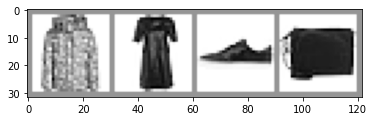

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

## The Model

The model we’ll use in this example is a variant of LeNet-5 - it should be familiar if you’ve watched the previous videos in this series.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


aamodel = GarmentClassifier()

## Loss Function

For this example, we’ll be using a cross-entropy loss. For demonstration purposes, we’ll create batches of dummy output and label values, run them through the loss function, and examine the result.

In [15]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.6889, 0.6805, 0.3211, 0.5526, 0.2367, 0.7736, 0.1772, 0.7836, 0.4820,
         0.2474],
        [0.8385, 0.8935, 0.9638, 0.8233, 0.9678, 0.8846, 0.0187, 0.4019, 0.2250,
         0.2561],
        [0.0915, 0.6818, 0.6721, 0.3137, 0.5893, 0.1585, 0.6923, 0.9095, 0.7647,
         0.5656],
        [0.2671, 0.4035, 0.7341, 0.7041, 0.1994, 0.1907, 0.2276, 0.5765, 0.0372,
         0.9894]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.251607894897461
